In [10]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.video import r3d_18, R3D_18_Weights
import torch.nn as nn

# Force use of CPU only:
device = torch.device("cpu")
print("✅ Using device:", device)


✅ Using device: cpu


In [11]:
class VideoDataset(Dataset):
    def __init__(self, video_dir, clip_len=16, transform=None):
        self.video_paths = []
        self.labels = []
        self.clip_len = clip_len
        self.transform = transform

        # Collect folders as classes
        class_folders = sorted([
            d for d in os.listdir(video_dir)
            if os.path.isdir(os.path.join(video_dir, d))
        ])
        self.class_to_idx = {cls: i for i, cls in enumerate(class_folders)}
        self.classes = class_folders
        print("Classes found:", self.classes)
        print("Class->idx map:", self.class_to_idx)

        # Gather video paths and labels
        for cls in class_folders:
            class_path = os.path.join(video_dir, cls)
            for file in os.listdir(class_path):
                if file.endswith('.mp4'):
                    self.video_paths.append(os.path.join(class_path, file))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.labels[idx]
        cap = cv2.VideoCapture(path)

        frames = []
        while len(frames) < self.clip_len:
            ret, frame = cap.read()
            if not ret:
                break
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(img_rgb)
            if self.transform:
                tensor = self.transform(pil_img)
                frames.append(tensor)

        cap.release()

        # Pad if not enough frames
        if len(frames) < self.clip_len:
            for _ in range(self.clip_len - len(frames)):
                frames.append(frames[-1])

        # Shape: (channels=3, time=clip_len, height, width)
        clip = torch.stack(frames[:self.clip_len], dim=1)
        return clip, label


In [12]:
from collections import Counter

# Transform definition
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.43216, 0.394666, 0.37645],
                         [0.22803, 0.22145, 0.216989]),
])

# Build your dataset
data_dir = "dataset/videos"
dataset = VideoDataset(data_dir, clip_len=16, transform=transform)

if len(dataset) == 0:
    raise ValueError("❌ Dataset is empty. Please check the dataset path/folders.")

# Split train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
if train_size == 0 or val_size == 0:
    raise ValueError("❌ Not enough data to split into train and val sets.")

train_ds, val_ds = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

# Check labels
classes = dataset.classes
unique_labels = sorted(set(label for _, label in train_ds))
print("✅ Unique labels in training set:", unique_labels)

# Must match range [0..len(classes)-1]
for label in unique_labels:
    if label < 0 or label >= len(classes):
        raise ValueError(
            f"Label {label} is out of range! Valid range: [0..{len(classes)-1}]"
        )

# -------------------------------------------------------------------
#  Class Weight Computation (to handle class imbalance)
# -------------------------------------------------------------------
class_counts = Counter(lbl for _, lbl in train_ds)
print("Class counts in training set:", {classes[k]: v for k, v in class_counts.items()})

max_count = max(class_counts.values())
weights = []
for i in range(len(classes)):
    # If class i is missing or zero (unlikely), use 1 to avoid divide-by-zero
    count_i = class_counts.get(i, 1)
    # Weighted by ratio to largest class
    w_i = max_count / count_i
    weights.append(w_i)

print("Class weights:", weights)
weights_tensor = torch.FloatTensor(weights).to(device)


Classes found: ['bench press', 'deadlift', 'squat']
Class->idx map: {'bench press': 0, 'deadlift': 1, 'squat': 2}
✅ Unique labels in training set: [0, 1, 2]
Class counts in training set: {'bench press': 49, 'squat': 19, 'deadlift': 24}
Class weights: [1.0, 2.0416666666666665, 2.5789473684210527]


In [13]:
# Build model (on CPU)
model = r3d_18(weights=R3D_18_Weights.KINETICS400_V1)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)
print("✅ Model on device:", next(model.parameters()).device)

# Use CrossEntropyLoss with class weighting
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


✅ Model on device: cpu


In [14]:
num_epochs = 10

# (Optional) to store metrics for plotting later
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    ########################################################################
    # 1) Training Pass
    ########################################################################
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        # Compute accuracy for this batch
        _, preds = torch.max(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_acc = correct_train / total_train

    ########################################################################
    # 2) Validation Pass
    ########################################################################
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, preds = torch.max(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_acc = correct_val / total_val

    ########################################################################
    # 3) Print & Store Metrics
    ########################################################################
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/10] Train Loss: 0.8809 | Train Acc: 0.5978 Val Loss: 0.2029 | Val Acc: 1.0000
Epoch [2/10] Train Loss: 0.7188 | Train Acc: 0.7283 Val Loss: 0.2259 | Val Acc: 0.8750
Epoch [3/10] Train Loss: 0.3676 | Train Acc: 0.8804 Val Loss: 0.1216 | Val Acc: 0.9583
Epoch [4/10] Train Loss: 0.4664 | Train Acc: 0.8587 Val Loss: 0.2219 | Val Acc: 0.9167
Epoch [5/10] Train Loss: 0.4171 | Train Acc: 0.9022 Val Loss: 0.0990 | Val Acc: 0.9583
Epoch [6/10] Train Loss: 0.3711 | Train Acc: 0.9239 Val Loss: 0.0875 | Val Acc: 1.0000
Epoch [7/10] Train Loss: 0.2931 | Train Acc: 0.9239 Val Loss: 0.0748 | Val Acc: 1.0000
Epoch [8/10] Train Loss: 0.3272 | Train Acc: 0.9239 Val Loss: 0.2526 | Val Acc: 0.9167
Epoch [9/10] Train Loss: 0.2784 | Train Acc: 0.9348 Val Loss: 0.0800 | Val Acc: 0.9583
Epoch [10/10] Train Loss: 0.2170 | Train Acc: 0.9674 Val Loss: 0.0523 | Val Acc: 1.0000


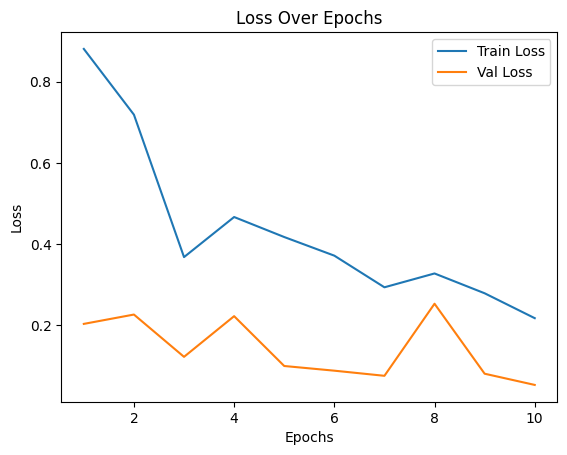

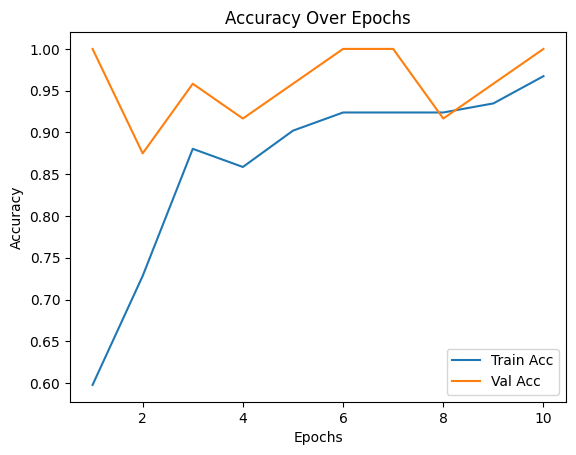

In [15]:
import matplotlib.pyplot as plt

# 1) Plot Loss Over Epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_loss_list, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

# 2) Plot Accuracy Over Epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Acc")
plt.plot(range(1, num_epochs + 1), val_acc_list, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()


In [16]:
import os

# Make sure the directory exists (creates it if needed)
os.makedirs("models", exist_ok=True)

# Save the state_dict of your trained model
save_path = "models/model_r3d18_3cat_wweights.pth"
torch.save(model.state_dict(), save_path)

print(f"💾 Model saved to {save_path}")


💾 Model saved to models/model_r3d18_3cat_wweights.pth
